# **Imports**

In [1]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# **Data Preparation**

In [2]:
folders = glob('/kaggle/input/esophagealcancer' + '/*')
print('New Paths: ', folders)

IMAGE_FILES = glob('/kaggle/input/esophagealcancer/Endoscopy-esophagus' + '/*/*.*')
print('Images Count: ', len(IMAGE_FILES))

New Paths:  ['/kaggle/input/esophagealcancer/Endoscopy-esophagus']
Images Count:  10662


# **Showing Sample Images**

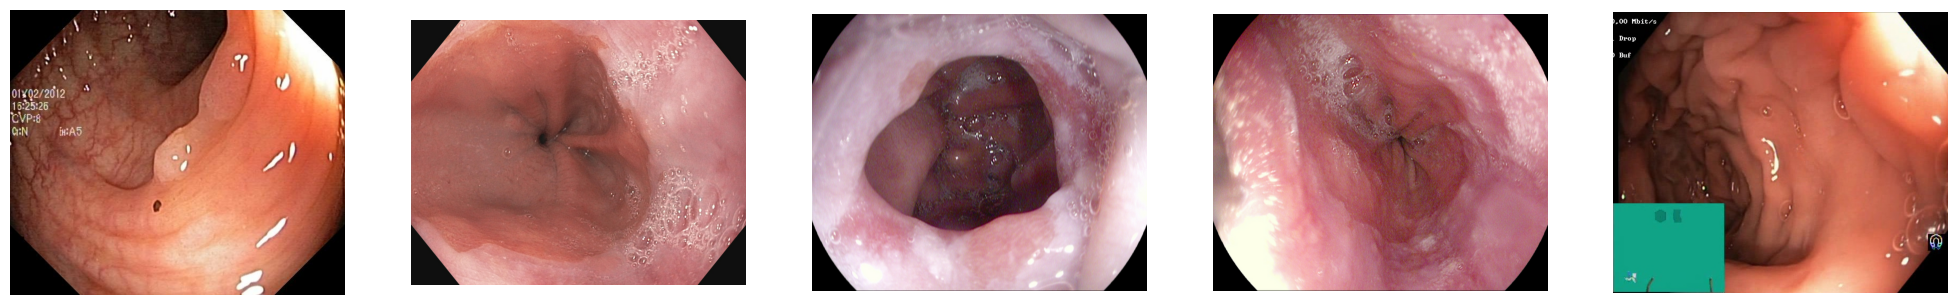

In [3]:
SAMPLES = ["/kaggle/input/esophagealcancer/Endoscopy-esophagus/no-esophagus/0004a718-546c-41c2-9c69-c4685093a039.jpg",
           '/kaggle/input/esophagealcancer/Endoscopy-esophagus/esophagus/001dcfa9-0cac-4b07-9cec-bc70944cd4d3.jpg', 
           '/kaggle/input/esophagealcancer/Endoscopy-esophagus/esophagus/029e4210-dcc0-4350-92e4-9bd075ca31df.jpg',
           '/kaggle/input/esophagealcancer/Endoscopy-esophagus/esophagus/00515123-4d92-412b-85de-997cd047a2df.jpg', 
           '/kaggle/input/esophagealcancer/Endoscopy-esophagus/no-esophagus/002b8801-99f5-4e6b-ac0a-84995cb76fd5.jpg']

plt.figure(figsize=(25, 10)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

# **Generating Data**

In [4]:
data_dir = '/kaggle/input/esophagealcancer/Endoscopy-esophagus'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

X = Y = 299

training = data.flow_from_directory(data_dir,
                                    class_mode = "binary",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "binary",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 8531 images belonging to 2 classes.
Found 2131 images belonging to 2 classes.


In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

In [6]:
IMG_SHAPE = (X,Y) +(3,)
base_model = tf.keras.applications.ConvNeXtTiny(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')

111650432/111650432 [==============================] - 1s 0us/step


In [7]:
type(base_model)
preprocess_input = tf.keras.applications.convnext.preprocess_input

In [8]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name) 

Numbers of Layers = 151
tf.__operators__.add_17
layer_normalization


In [9]:
# iterate over first batch (32 image) in trainset 
image_batch, label_batch = next(iter(training))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 9, 9, 768)


In [10]:
def EsophagealCancer_Model( image_shape=(X,Y)):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)
    
    resnet_model = tf.keras.applications.ConvNeXtTiny(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 144]:
        layer.trainable = False
    
    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs) 
    model.summary()
    return model

In [11]:
EsophagealCancer_Model = EsophagealCancer_Model((X,Y))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 convnext_tiny (Functional)  (None, 9, 9, 768)         27820128  
                                                                 
 global_average_pooling2d (G  (None, 768)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 27,820,897
Trainable params: 4,725,505
Non-trainable params: 23,095,392
_________________________________________

In [12]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)
                        
checkpoint=tf.keras.callbacks.ModelCheckpoint(
     './checkpoints', 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    period=5
)
callback=[earlystop,checkpoint,tensorboard_callback]

In [13]:
import keras 
base_learning_rate = 0.001
EsophagealCancer_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss = tf.keras.losses.BinaryCrossentropy(),
                           metrics=['accuracy' , tf.keras.metrics.Precision()])

In [14]:
history = EsophagealCancer_Model.fit(training , verbose=1 , epochs=3,
                               validation_data=validation , use_multiprocessing= True)

Epoch 1/3
67/67 [==============================] - 712s 10s/step - loss: 0.1506 - accuracy: 0.9585 - precision: 0.9668 - val_loss: 0.0707 - val_accuracy: 0.9765 - val_precision: 1.0000
Epoch 2/3
67/67 [==============================] - 573s 9s/step - loss: 0.0112 - accuracy: 0.9960 - precision: 0.9982 - val_loss: 0.0100 - val_accuracy: 0.9962 - val_precision: 0.9972
Epoch 3/3
67/67 [==============================] - 651s 10s/step - loss: 0.0022 - accuracy: 0.9996 - precision: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9967 - val_precision: 0.9967


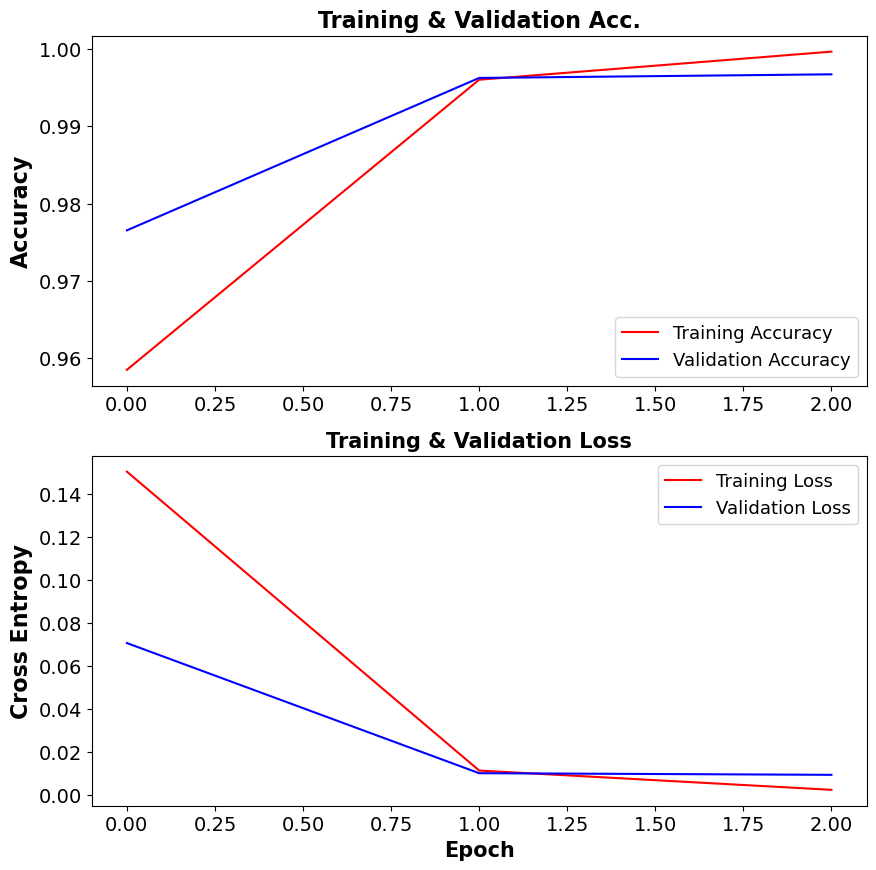

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()